This is for using 4 channels, one brightfield and 3 fluorescent in the autoencoder.

### This is using compensated images
- Data directory: '/media/cjw/Data/cyto/mmFromTifs3/'
- Checkpoint directory;: "/media/cjw/Data/cyto/Checkpoints/2018-04-17-Chs-0-1-2-4_32_mmFromTifs3/checkpoint-2018-04-17-10-18-24/"
- Checkpoint file: 'autoencoder-256x-13980.meta'

In [1]:
import sys

In [2]:
sys.executable

'/home/cjw/anaconda3/bin/python'

In [3]:
'''
Import the modules that will be used
'''

import sys
import warnings
from distutils.version import LooseVersion
import os

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
#import hdbscan

from autoencoder import network
from autoencoder import utils

%matplotlib inline
%pwd

/home/cjw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'/home/cjw/Code/DeepLearning/autoencoder/AutoEncoder_Compensated'

In [4]:
tf.__version__

'1.6.0'

In [5]:
datadir =  '/v/Data/cyto/mmCompensatedTifs/'
#datadir =  '/media/cjw/Data/cyto/mmCompensatedTifs/

#cp_dir = '/home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-19-11-19-18/'

cp_dir = "/v/Data/cyto/Checkpoints/2018-06-08-512/checkpoint-2018-06-08-20-20-24/"
aemeta = 'autoencoder-256x-140500.meta'
# cp_dir = "/media/cjw/Data/cyto/Checkpoints/2018-06-04-512/checkpoint-2018-06-04-16-36-15/"
# aemeta = 'autoencoder-512x-25290.meta'

if os.path.exists(cp_dir + aemeta):
    print("OK")

OK


In [6]:
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()
                  
print(cp_dir)

if os.path.exists(cp_dir):
    print("OK, exists")
else:
    print("Oh no")
#checkpoint-2018-03-02-16-31-42/'
p_width = 32
p_height = 32
p_nchannels = 3
p_channels = [0,2,4]
p_nepochs = 40
p_batchsize = 128
p_learning_rate = 0.0002  #.00005
p_restore = False
p_latent_size = 256 #64
p_droprate = 0.95
p_stdev = .04
p_slam = .05
p_denoise = None

enc_sizes = [(128, 3), (256, 3), (512, 3)] 
#enc_sizes = [(128, 3), (256, 3), (512,3), (1024,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
dec_sizes = list(reversed(enc_sizes))
# enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)]
# dec_sizes = list(reversed(enc_sizes))

images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
z = tf.placeholder(tf.float32, (None, p_latent_size))

images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
z = tf.placeholder(tf.float32, (None, p_latent_size))

enc = network.encoder(images, p_latent_size, droprate=p_droprate, is_train=False,
                      nfilters=enc_sizes)
sdd = network.decoder(enc, nchannels=p_nchannels, width=p_width, droprate=p_droprate,
                      is_train=False, nfilters=dec_sizes)

loss, _, _ = network.ae_loss(images, sdd)

opt = network.model_opt(loss, p_learning_rate)

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + aemeta) #autoencoder-64x-18660.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))


/v/Data/cyto/Checkpoints/2018-06-08-512/checkpoint-2018-06-08-20-20-24/
OK, exists
Encoder False
Tensor("Placeholder_2:0", shape=(?, 32, 32, 3), dtype=float32) (?, 32, 32, 3)
isize:  4 32
dh0 (?, 32, 32, 3)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /v/Data/cyto/Checkpoints/2018-06-08-512/checkpoint-2018-06-08-20-20-24/autoencoder-256x-140500


In [7]:
#datadir = "/media/cjw/Data/cyto/mmFromTifs/"
#datadir = "/home/cjw/disk2cjw/Data/yeast/"
mmfiles = utils.list_mmfiles(datadir)
print(mmfiles)

mmdict = dict()

n_all_images = 0
for mmfilename in mmfiles:
#mmfilename = datadir + "Fish6_15_cjw_mean_zero.mm"
#mmfilename = datadir + "mmplate15-1.mm"
    mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

    header_shape = mmheader.shape
    print(header_shape, mmheader)
    xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
    xshape = tuple(xshape)
    del mmheader
    n_all_images += xshape[0]
    
    m3 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)
    key = mmfilename.split("/")[-1]
    mmdict[key] = m3

print(n_all_images)
mmdict.keys()

['/v/Data/cyto/mmCompensatedTifs/Fish4_Untreated.mm', '/v/Data/cyto/mmCompensatedTifs/Fish3_CCB.mm', '/v/Data/cyto/mmCompensatedTifs/Fish4_CCB.mm', '/v/Data/cyto/mmCompensatedTifs/Fish1_Untreated.mm', '/v/Data/cyto/mmCompensatedTifs/Fish2_ICE.mm', '/v/Data/cyto/mmCompensatedTifs/Fish2_CCB.mm', '/v/Data/cyto/mmCompensatedTifs/Fish5_CCB.mm', '/v/Data/cyto/mmCompensatedTifs/Fish1_Ice.mm', '/v/Data/cyto/mmCompensatedTifs/Fish6_CCB.mm', '/v/Data/cyto/mmCompensatedTifs/Fish3_Untreated.mm', '/v/Data/cyto/mmCompensatedTifs/Fish4_ICE.mm', '/v/Data/cyto/mmCompensatedTifs/Fish6_ICE.mm', '/v/Data/cyto/mmCompensatedTifs/Fish3_ICE.mm', '/v/Data/cyto/mmCompensatedTifs/Fish6_Untreated.mm', '/v/Data/cyto/mmCompensatedTifs/Fish2_Untreated.mm', '/v/Data/cyto/mmCompensatedTifs/Fish5_Untreated.mm', '/v/Data/cyto/mmCompensatedTifs/Fish1_CCB.mm', '/v/Data/cyto/mmCompensatedTifs/Fish5_ICE.mm']
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
(4,) [10000    64    64 

dict_keys(['Fish4_Untreated.mm', 'Fish3_CCB.mm', 'Fish4_CCB.mm', 'Fish1_Untreated.mm', 'Fish2_ICE.mm', 'Fish2_CCB.mm', 'Fish5_CCB.mm', 'Fish1_Ice.mm', 'Fish6_CCB.mm', 'Fish3_Untreated.mm', 'Fish4_ICE.mm', 'Fish6_ICE.mm', 'Fish3_ICE.mm', 'Fish6_Untreated.mm', 'Fish2_Untreated.mm', 'Fish5_Untreated.mm', 'Fish1_CCB.mm', 'Fish5_ICE.mm'])

In [8]:
n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
for key in mmdict.keys():
    mm = mmdict[key]
    n = mm.shape[0]
    file = n*[key[0:-3]]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)
    
alldf = pd.concat(dataframes, ignore_index=True)
trts = list()
runs = list()

ufiles = alldf['file'].unique()
ufd = dict()
for i, f in enumerate(ufiles):
    ufd[f] = i

alldf['fnum'] = alldf['file'].map(ufd)


for row in range(len(alldf)):
    file = alldf.iloc[row]['file']
    if '_ice' in file.lower():
        treatment = 'ice'
    elif '_ccb'in file.lower():
        treatment = 'ccb'
    else:
        treatment = "untreated"
    trts.append(treatment)
    runs.append(file[0:5])

alldf['treatment'] = trts
alldf['run'] = runs
df = alldf.sample(frac=.025)
df = df.reset_index()
print(len(df))
df.tail()

4500


index  column   fid  field             file      id  \
4495    5033       0  5033      0  Fish4_Untreated    5033   
4496  106369       0  6369      0        Fish4_ICE  106369   
4497  119214       0  9214      0        Fish6_ICE  119214   
4498   89385       0  9385      0        Fish6_CCB   89385   
4499  119415       0  9415      0        Fish6_ICE  119415   

                  mmfile  plate  row  well  xc  yc  fnum  treatment    run  
4495  Fish4_Untreated.mm      0    0     0  32  32     0  untreated  Fish4  
4496        Fish4_ICE.mm      0    0     0  32  32    10        ice  Fish4  
4497        Fish6_ICE.mm      0    0     0  32  32    11        ice  Fish6  
4498        Fish6_CCB.mm      0    0     0  32  32     8        ccb  Fish6  
4499        Fish6_ICE.mm      0    0     0  32  32    11        ice  Fish6

In [9]:
sns.set_style("whitegrid", {'axes.grid' : False})
len(df)

4500

In [10]:
vv = utils.getWell(mmdict,
                    df, p_width, 0, 0, p_nchannels, channels=p_channels)

(4500, 256) (4500, 32, 32, 3)
0.07827191799879074 1.1028857231140137


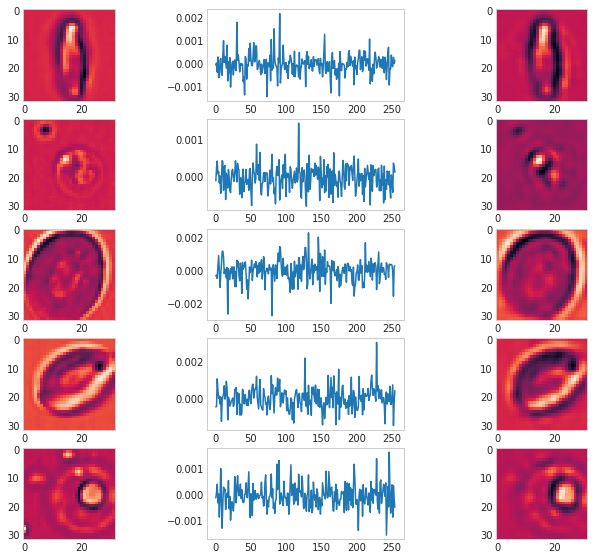

In [11]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, p_width, 0, 0, p_nchannels, channels=p_channels)

nvv = len(vv)
offloc = 0
offstep = 1000
offnext = offloc + offstep
xhe = np.zeros((nvv, p_latent_size))
xdd = np.zeros((nvv, p_width, p_height, p_nchannels))
while offloc < nvv:
    #print(offloc, offnext)
    xhe[offloc:offnext] = sess.run(enc, feed_dict={images:vv[offloc:offnext]})
    xdd[offloc:offnext] = sess.run(sdd, feed_dict={enc:xhe[offloc:offnext]})
    offloc = offnext
    offnext += offstep
    if offnext > nvv:
        offnext = nvv
        
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
for i in range(5):
    ix = np.random.randint(0, len(vv))
    #print(ix)
    plt.subplot(20,3,i*3 + 1)
    plt.imshow(vv[ix,:,:,0])
    plt.subplot(20,3,i*3 + 2)
    plt.plot(xhe[ix])
    plt.subplot(20,3,i*3 + 3)
    plt.imshow(xdd[ix,:,:,0])

In [12]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = xhe #sess.run(enc, feed_dict={images:k})
    print('hek', hek.shape)
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape





0 0
4500
hek (4500, 256)
0 0 (4500, 256) (4500, 256)


(4500, 256)

In [16]:
from sklearn.preprocessing import normalize
g_all = normalize(g_all, axis=1)

In [13]:
from sklearn.manifold import TSNE

g_emb = TSNE(n_components=2,perplexity=25).fit_transform(g_all.astype(np.float64))
print(g_emb.shape)

(4500, 2)


In [14]:
''' Create some colors for display later on'''

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255),
         (1, 0,0), (0,1,0), (0,0,1)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] 10


In [15]:
'''Do PCA on the latent space features'''

from sklearn.decomposition import PCA
pca = PCA(n_components=32, svd_solver='arpack', whiten=True, copy=True)
gfit = pca.fit_transform(g_all)
print(gfit.shape)
print(pca.explained_variance_ratio_)
print(pca.components_.shape)


(4500, 32)
[0.04334015 0.04202603 0.03050741 0.02909484 0.02666451 0.02380639
 0.02193014 0.02007401 0.01895758 0.01721508 0.01684341 0.01660447
 0.01539288 0.01464265 0.01416314 0.01338344 0.01271041 0.01247133
 0.01201945 0.01139528 0.01114876 0.01067812 0.01031373 0.0099113
 0.0094832  0.00940897 0.00919308 0.00883818 0.0087155  0.00847271
 0.00837286 0.00775187]
(32, 256)


In [17]:
'''
Do clustering on the latent space features
find eight cluster for K-Means and Allomerative Clustering
'''

nclust = 27
from sklearn import cluster, mixture
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

#km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
#agc = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward").fit_predict(g_all)

gmm = BayesianGaussianMixture(nclust, weight_concentration_prior_type="dirichlet_process",covariance_type='full',
                              reg_covar=0, init_params='kmeans', tol=1e-3, verbose=2, verbose_interval=500,
                              max_iter=4500, mean_precision_prior=.8)
                              
gmm.weight_concentration_prior = 1./len(g_all)
gmm.fit(g_all)
gm = gmm.predict(g_all)

# gmm1 = BayesianGaussianMixture(nclust, covariance_type='full')
# gmm1.fit(g_emb)
# gm1 = gmm1.predict(g_emb)

Initialization 0
  Iteration 0	 time lapse 2.00800s	 ll change inf
Initialization converged: True	 time lapse 3.09327s	 ll 24745279.59894


In [18]:
agc = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward").fit_predict(g_all)
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(nclust).fit_predict(g_all)

###  Show results of clustering using K-Means

Each row is a cluster found using the K-Means algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

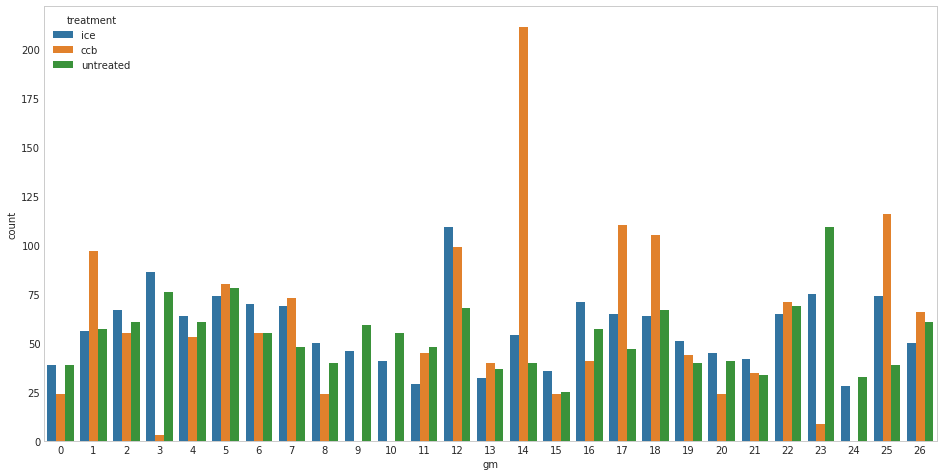

In [19]:
#km = gm
#df['km'] = km
df['gm'] = gm
plt.figure(figsize=(16,8))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.countplot(x='gm', data=df, hue='treatment')

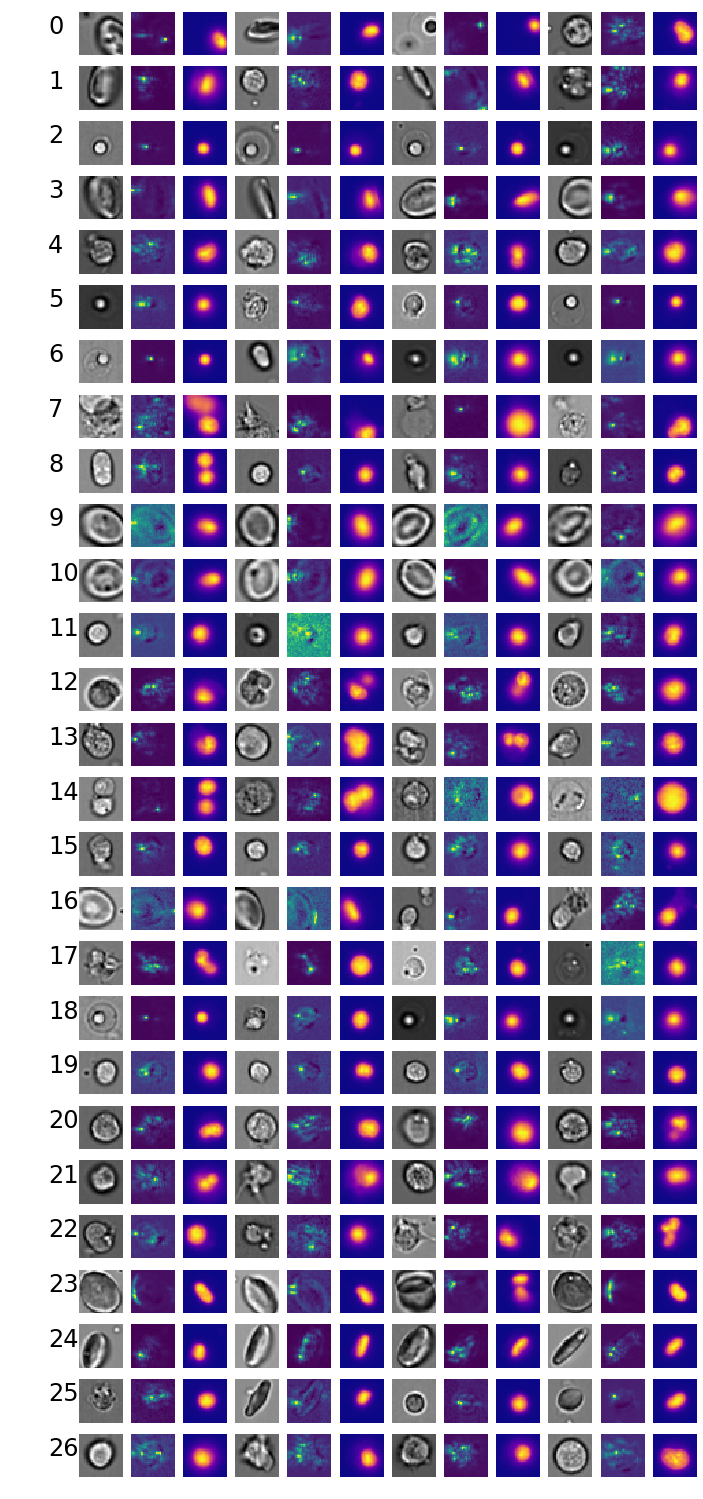

In [20]:
ximages = vv
nk = nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in range(nk):
    rowdf = df[df['gm'] == k]
    inum = list(rowdf.index)
    if len(inum) == 0:
        continue
#     gk = g_all[gm == k]
#     gavk = np.mean(gk, axis=0)
#     gavk = np.expand_dims(gavk.squeeze(), axis=0)
#    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 13, counter)
    plt.text(0.5,0.5, str(k), fontsize=24, color='black')
    plt.axis('off')
    counter += 1
    for i in range(4):
        
        try:
            plt.subplot(nk, 13, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='viridis')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,2], cmap='plasma')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(rnd, df.iloc[rnd]['mmfile'])
        except Exception as e:
            #print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1

###  Show results of clustering using Agglomerative Clustering

Each row is a cluster found using the [Agglomerative Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

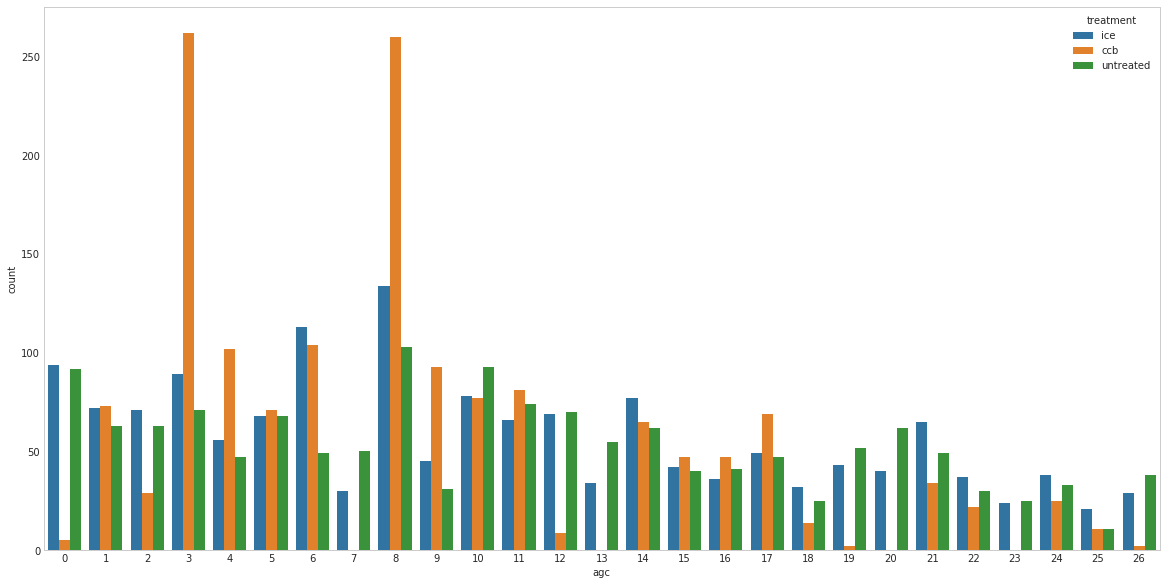

In [21]:
df['agc'] = agc
df['sc'] = sc
plt.figure(figsize=(20,10))
sns.countplot(x='agc', data=df, hue='treatment')
#plt.savefig('/media/cjw/Data/cyto/output/agc_filedist.png')

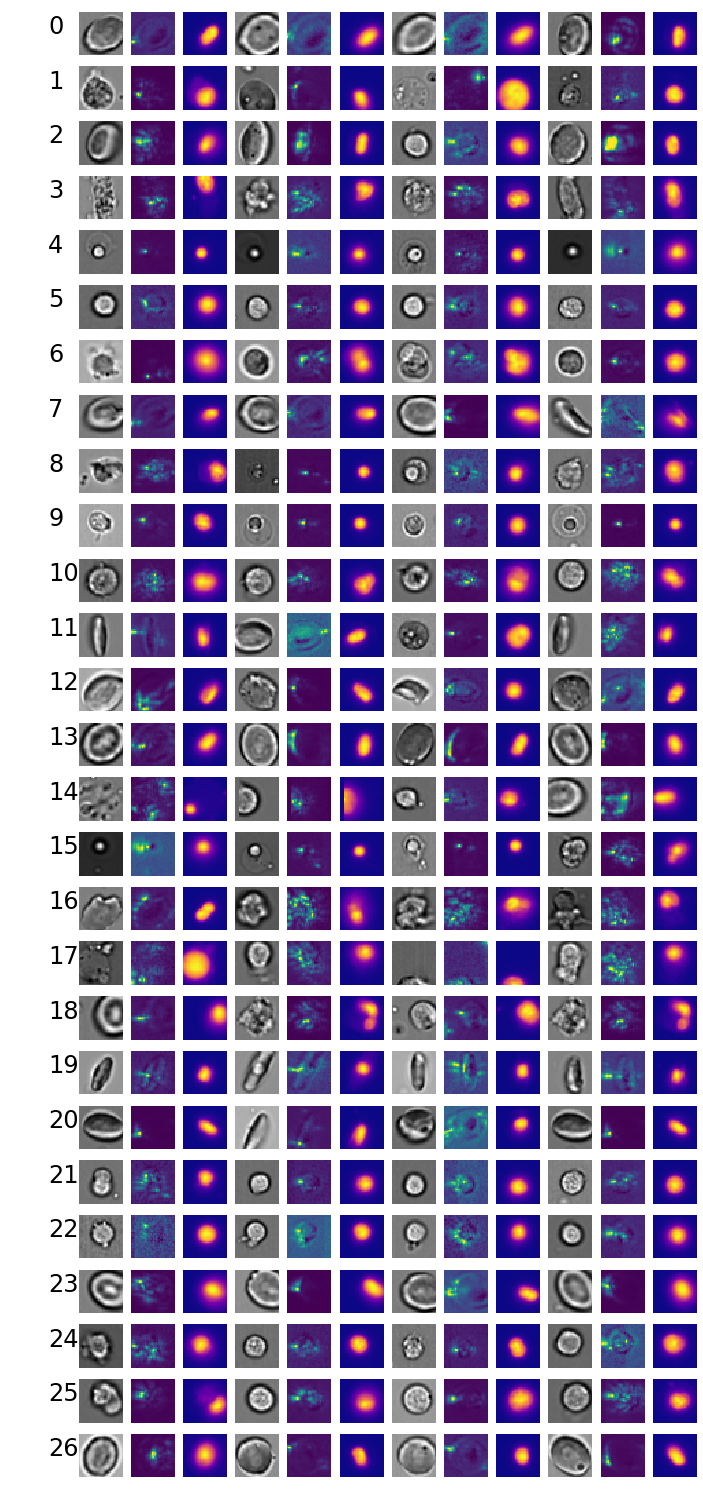

In [22]:
ximages = vv
nk = nclust
plt.figure(figsize=(12, 1.*nk))
plt.ion()
counter = 1
shift = 0
for k in range(nk):
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
#    resav = sess.run(sdd, feed_dict={enc:gavk})
#     plt.subplot(nk, 12, counter)
#     plt.imshow(resav.squeeze()[0])
#     plt.text(8, 12,str(k), fontsize=36, color='black')
#     counter += 1
    plt.subplot(nk, 13, counter)
    plt.text(0.5,0.5, str(k), fontsize=24, color='black')
    plt.axis('off')
    counter += 1
    for i in range(4):
        
        try:
            plt.subplot(nk, 13, counter)
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.axis('off')
            counter += 1
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,1], cmap='viridis')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            
            plt.subplot(nk, 13, counter)
            plt.imshow(ximages[rnd,:,:,2], cmap='plasma')
            plt.axis('off')
#             plt.text(5, 5,str(rnd), fontsize=20, color='white')
            counter += 1
            #print(rnd, df.iloc[rnd]['mmfile'])
        except Exception as e:
            print(e)
            plt.imshow(np.zeros((64,64)), cmap='gray')
            counter += 1

-------------------------------------------------------------------------

In [23]:
import matplotlib 
def display_cluster(cluster_num, nrows=16, outfile=None):
    
    if outfile:
        plt.ioff()
    tn = cluster_num
    images4 = ximages[agc == tn]
    g4 = g_all[agc == tn]
    fig = plt.figure(figsize=(16,1.6*1.5*nrows))
    #print(images4.shape)

#     gtest = np.mean(g4, axis=0)
#     gtest = np.expand_dims(gtest.squeeze(), axis=0)
#     res = sess.run(sdd, feed_dict={enc:gtest})

#     gav = np.mean(g_all, axis=0)
#     gav = np.expand_dims(gav.squeeze(), axis=0)
#     resav = sess.run(sdd, feed_dict={enc:gav})

    ppi = 0
    for i in range(nrows):
        ix = np.random.randint(0, len(g4))
        plt.subplot(nrows,8,i*8 + 1)
        plt.imshow(images4[ix,:,:,0], cmap='gray')
        plt.axis('off')

        plt.subplot(nrows,8,i*8 + 2)
        plt.imshow(images4[ix,:,:,1], cmap='viridis')
        plt.axis('off')

        plt.subplot(nrows,8, i*8 + 3)
        plt.imshow(images4[ix,:,:,2], cmap='plasma')
        plt.axis('off')

#         plt.subplot(nrows,8,i*8 + 4)
#         plt.imshow(images4[ix,:,:,3], cmap='afmhot')
#         plt.axis('off')

#         plt.subplot(nrows, 2, i*2 + 2)
#         plt.plot(g4[ix]*0, color='gray')
#         plt.plot(g4[ix])

    #     plt.xticks([])
    #     plt.yticks([])
        plt.axis('off')
        ppi += 2
    if outfile:
        #fig = matplotlib.pyplot.gcf()
        #fig.set_size_inches(4, 10)
        #fig.savefig('test2png.png', dpi=100)
        plt.savefig(outfile, dpi=100)
        plt.clf()
        plt.close(fig)
    
    plt.ion()



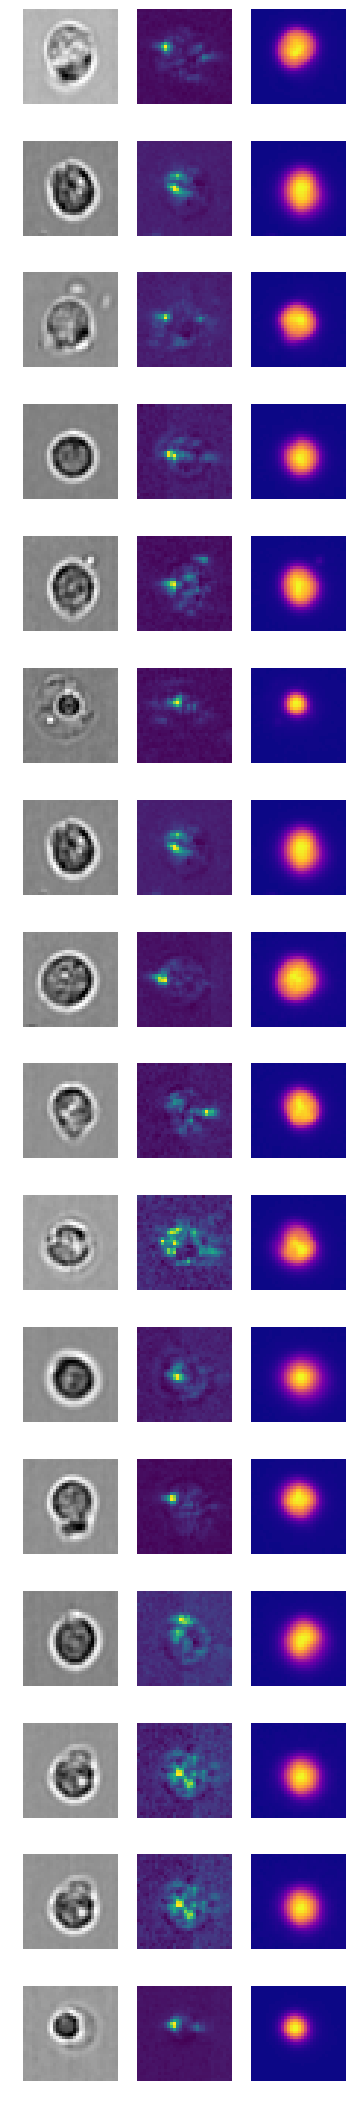

In [25]:
#for i in range(nclust):
outfile = None #"/media/cjw/Data/cyto/output/cluster_" + str(i).zfill(3) + ".png"
display_cluster(9, 16, outfile=outfile)

In [49]:
from sklearn.manifold import TSNE

# geez = list()
# ceez = list()
# cindex = 0
# for i in (16,17, 18,19):
#     gna = g_all[agc == i]
#     ca = cindex #np.array(clist[cindex])
#     cna = np.repeat([i], gna.shape[0], axis=0)
#     geez.append(gna)
#     ceez.append(cna)
#     cindex += 1
# # c3 = gn3.shape[0]*(1, 0, 0)
# # c6 = gn3.shape[0]*(0, 1, 0)
# # c10 = gn3.shape[0]*(0, 0, 1)
# gn = np.concatenate(geez)
# cn = np.concatenate(ceez)
# cn = np.concatenate((c3, c6, c10))
#print(gn.shape)
g_emb = TSNE(n_components=2,perplexity=25).fit_transform(g_all.astype(np.float64))
print(g_emb.shape)



(4500, 2)


In [26]:
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib gtk
# fig = plt.figure(figsize=(16,16))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(g_emb[:,0], g_emb[:,1], g_emb[:,2], s=8, c=gm,cmap='tab20c')

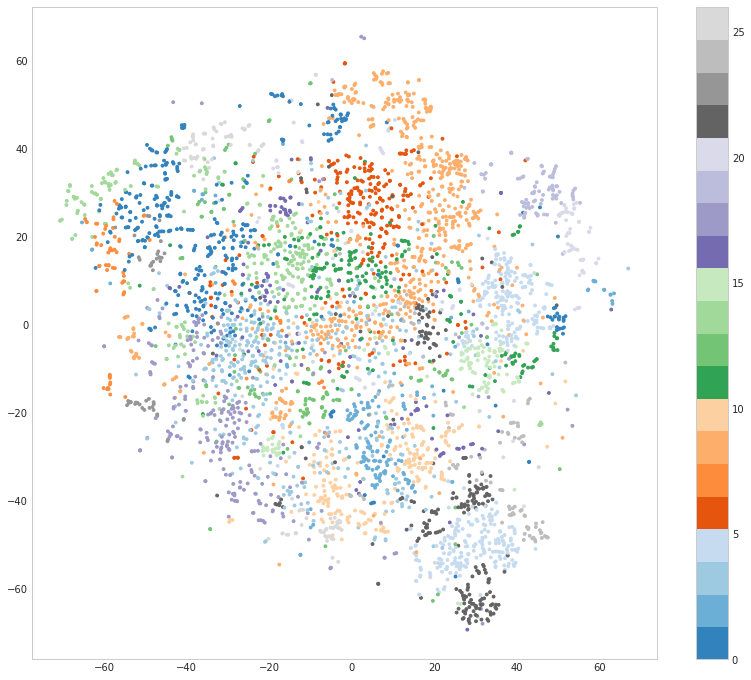

In [29]:
plt.figure(figsize=(14,12))
plt.scatter(g_emb[:,0], g_emb[:,1], 8, agc, cmap='tab20c')
plt.colorbar()
#test = y2[labels==0,:]
#plt.scatter(test[:,0],test[:,1], 4, 'black')

In [30]:
#km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(20).fit_predict(g_all)

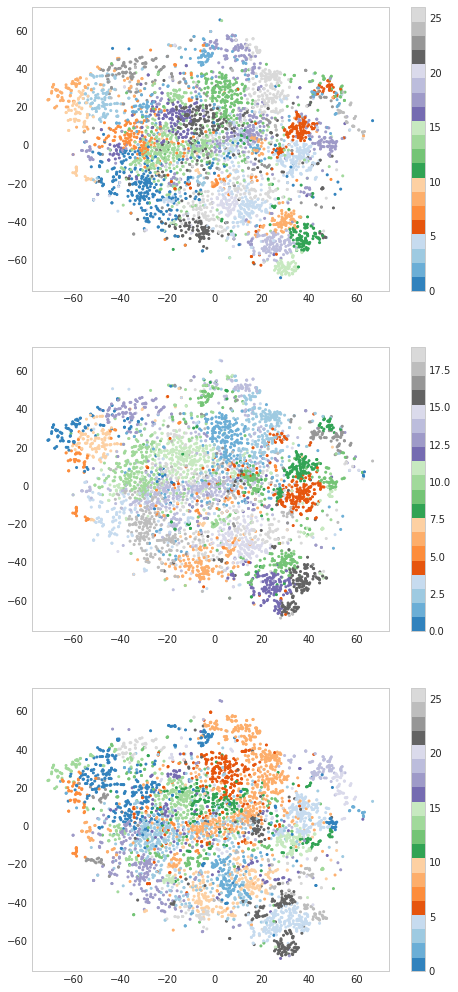

In [31]:
plt.figure(figsize=(8,24))
plt.subplot(4,1,1)
plt.scatter(g_emb[:,0], g_emb[:,1], 4, gm, cmap='tab20c')
plt.colorbar()

plt.subplot(4,1,2)
plt.scatter(g_emb[:,0], g_emb[:,1], 4, sc, cmap='tab20c')
plt.colorbar()

plt.subplot(4,1,3)
plt.scatter(g_emb[:,0], g_emb[:,1], 4, agc, cmap='tab20c')
plt.colorbar()

# plt.subplot(4,1,4)
# plt.scatter(g_emb[:,0], g_emb[:,1], 8, km, cmap='tab20c')
# plt.colorbar()
#test = y2[label

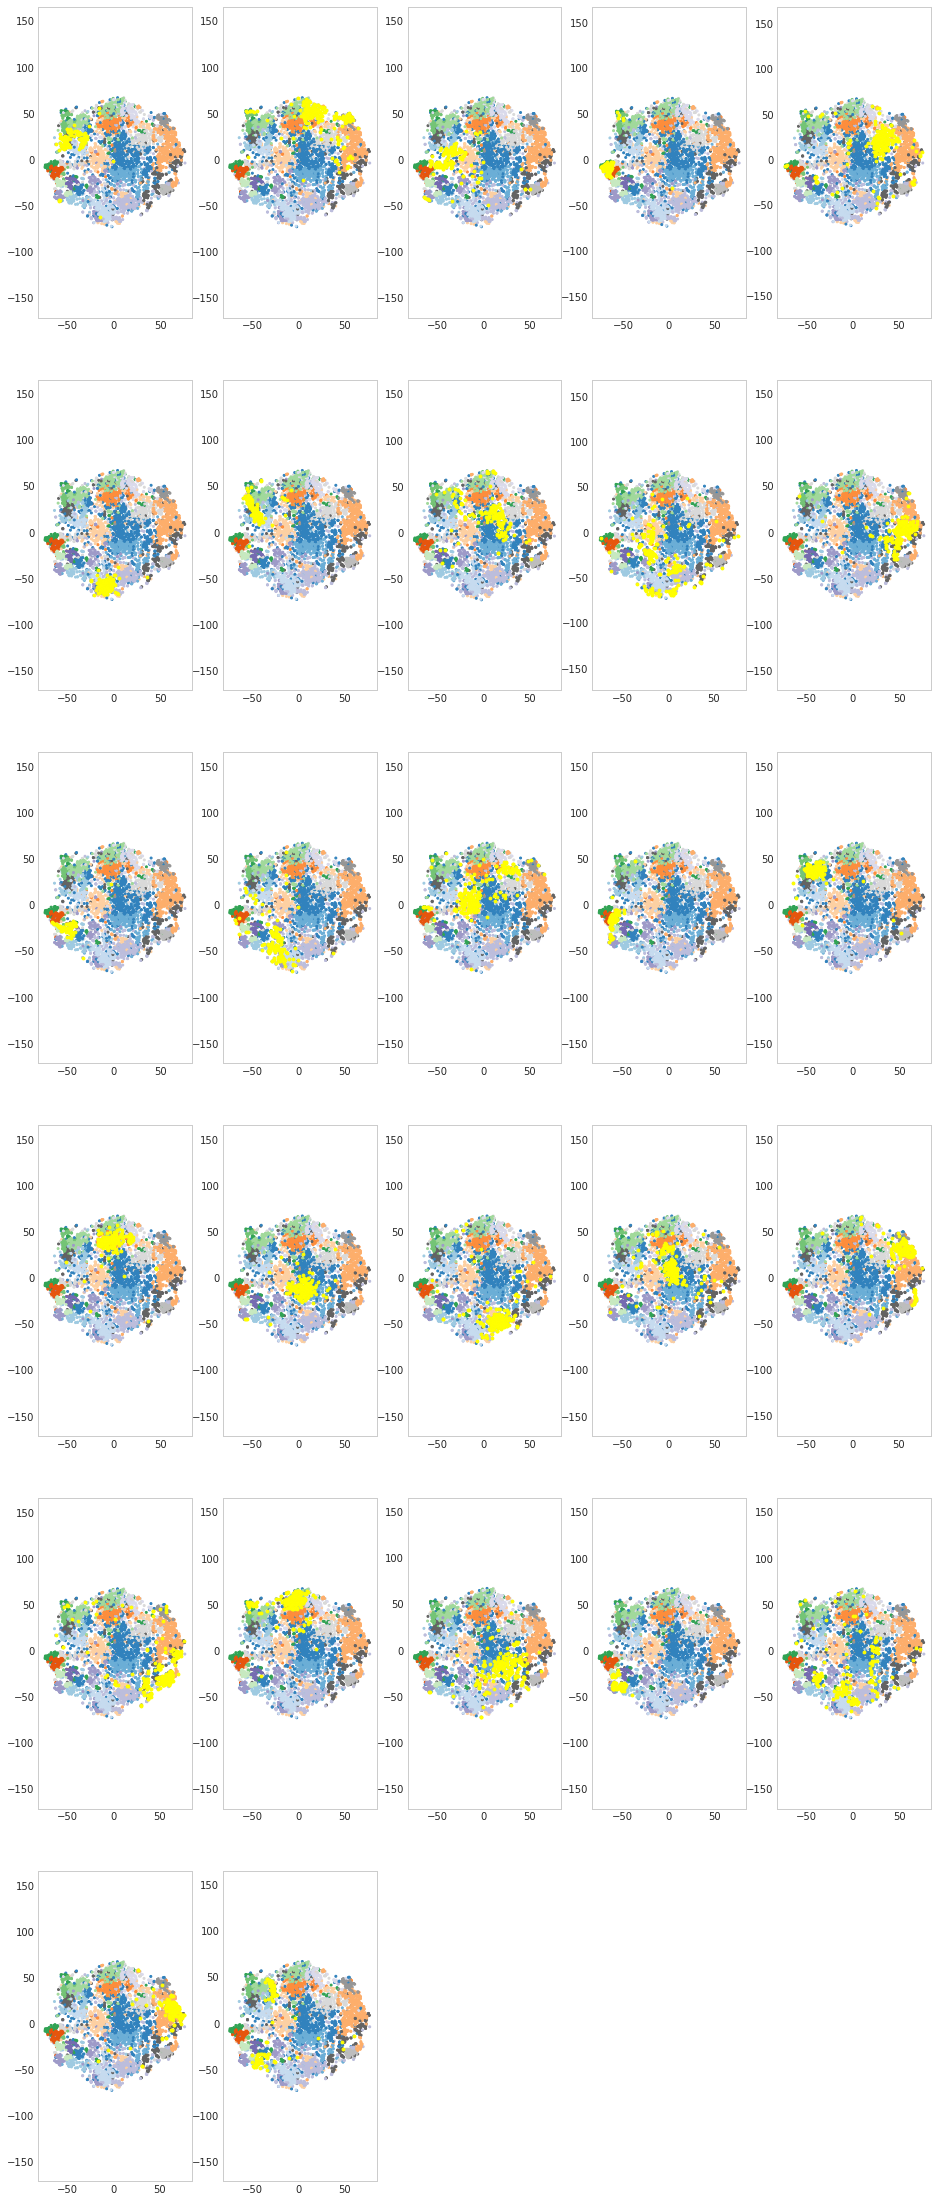

In [54]:
df['tsneX'] = g_emb[:,0]
df['tsneY'] = g_emb[:,1]

cs = ['black', 'gray', 'navy', 'blue',
      'slateblue', 'darkgreen', 'green', 'greenyellow',
     'gold', 'saddlebrown', 'salmon', 'orange']
ax = None

coi1 =  1
coi2 =  11
#plt.ioff()
plt.figure(figsize=(16,40))
for i in range(nclust):
        #ax = df[df['agc'] != i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color=gm, figsize=(6,6))
        ax = plt.subplot(nclust//4, 5, i + 1)
        plt.scatter(df['tsneX'], df['tsneY'], 4, agc, cmap='tab20c')
        xdf = df[df['gm'] == i]
        plt.scatter(xdf['tsneX'], xdf['tsneY'], label=i, s=8, color='yellow')
        ax.axis('equal')
        outfile = "/media/cjw/Data/cyto/output/tsne_" + str(i).zfill(3) + ".png"
        #plt.savefig(outfile, dpi=100)
        #plt.clf()
        #plt.close()
plt.ion()

In [56]:
#!pip install forceatlas2
import fa2

ModuleNotFoundError: No module named 'fa2'

In [250]:
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, cdist

dm =  np.arccos(1 -cdist(g_all,g_all, metric='cosine'))
#dm =  cdist(g_all, g_all, metric='euclidean')
#dm = distance_matrix(mma, mma)
print(dm.shape)

ddict = dict()
for i in range(g_all.shape[0]):
    ri = np.argsort(dm[i])
    ddict[i] = ri[1:13]

dm[1,ddict[1]]

(9000, 9000)


array([0.43258192, 0.44570004, 0.45263297, 0.46879161, 0.48347049,
       0.48629732, 0.49437837, 0.49692045, 0.49751535, 0.50763377,
       0.50879788, 0.51879843])

In [251]:

from fa2 import ForceAtlas2
import networkx as nx
ft = ForceAtlas2()

gx = nx.Graph()
pos = dict()
for i in range(g_all.shape[0]):
    gx.add_node(i)
    r1 = np.random.randint(-50, 50)
    r2 = np.random.randint(-50, 50)
    #pos[i] = (r1 + 1000*(yg[i]//8), r2 +1000*(yg[i] % 8)) 
    
#pos[38], yg[38]

In [252]:

index = 0
edges = list()
enum = 0
xnum = 0
for i in range(g_all.shape[0]):
    if i % 1000 == 0:
        print(i, xnum, enum, gx.size())
    for k in ddict[i]:
        if i == k:
            continue
   
        w = 1 #1./(w*w)
        if gx.has_edge(k, i):
            xnum += 1
        gx.add_edge(i, k, weight=w) #, weight=w)
        enum += 1
        #index += 1

print(enum, xnum)
#g.add_edges_from(edges)
#g.add_weighted_from(len(edges)*[1.])
len(gx.nodes()), len(gx.edges())

0 0 0 0
1000 348 12000 11652
2000 1372 24000 22628
3000 3152 36000 32848
4000 5491 48000 42509
5000 8604 60000 51396
6000 12328 72000 59672
7000 16936 84000 67064
8000 22251 96000 73749
108000 28044


(9000, 79956)

In [253]:
ft = ForceAtlas2( # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          #multiThreaded=True,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=10.,
                          strongGravityMode=False,
                          gravity= .0,

                          # Log
                          verbose=True)

In [254]:
p = ft.forceatlas2_networkx_layout(gx, pos=None, iterations=500)

100%|██████████| 500/500 [00:52<00:00,  9.57it/s]

BarnesHut Approximation  took  24.49  seconds
Repulsion forces  took  25.03  seconds
Gravitational forces  took  0.19  seconds
Attraction forces  took  0.72  seconds
AdjustSpeedAndApplyForces step  took  0.93  seconds


/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


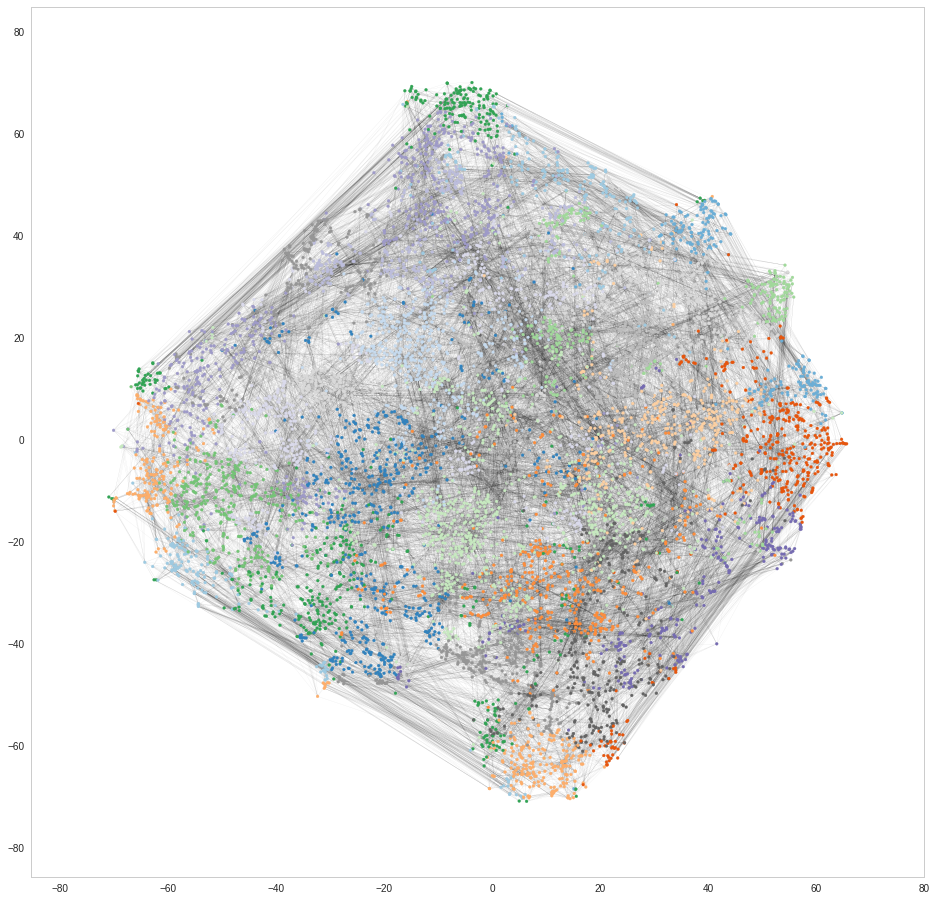

In [255]:

pos = dict()
for i in range(g_emb.shape[0]):
    pos[i] = (g_emb[i][0], g_emb[i][1])

plt.figure(figsize=(16,16))    
nx.draw_networkx(gx, pos, node_size=8, with_labels=False, width=.02, node_color=gm1,cmap='tab20c')    

/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


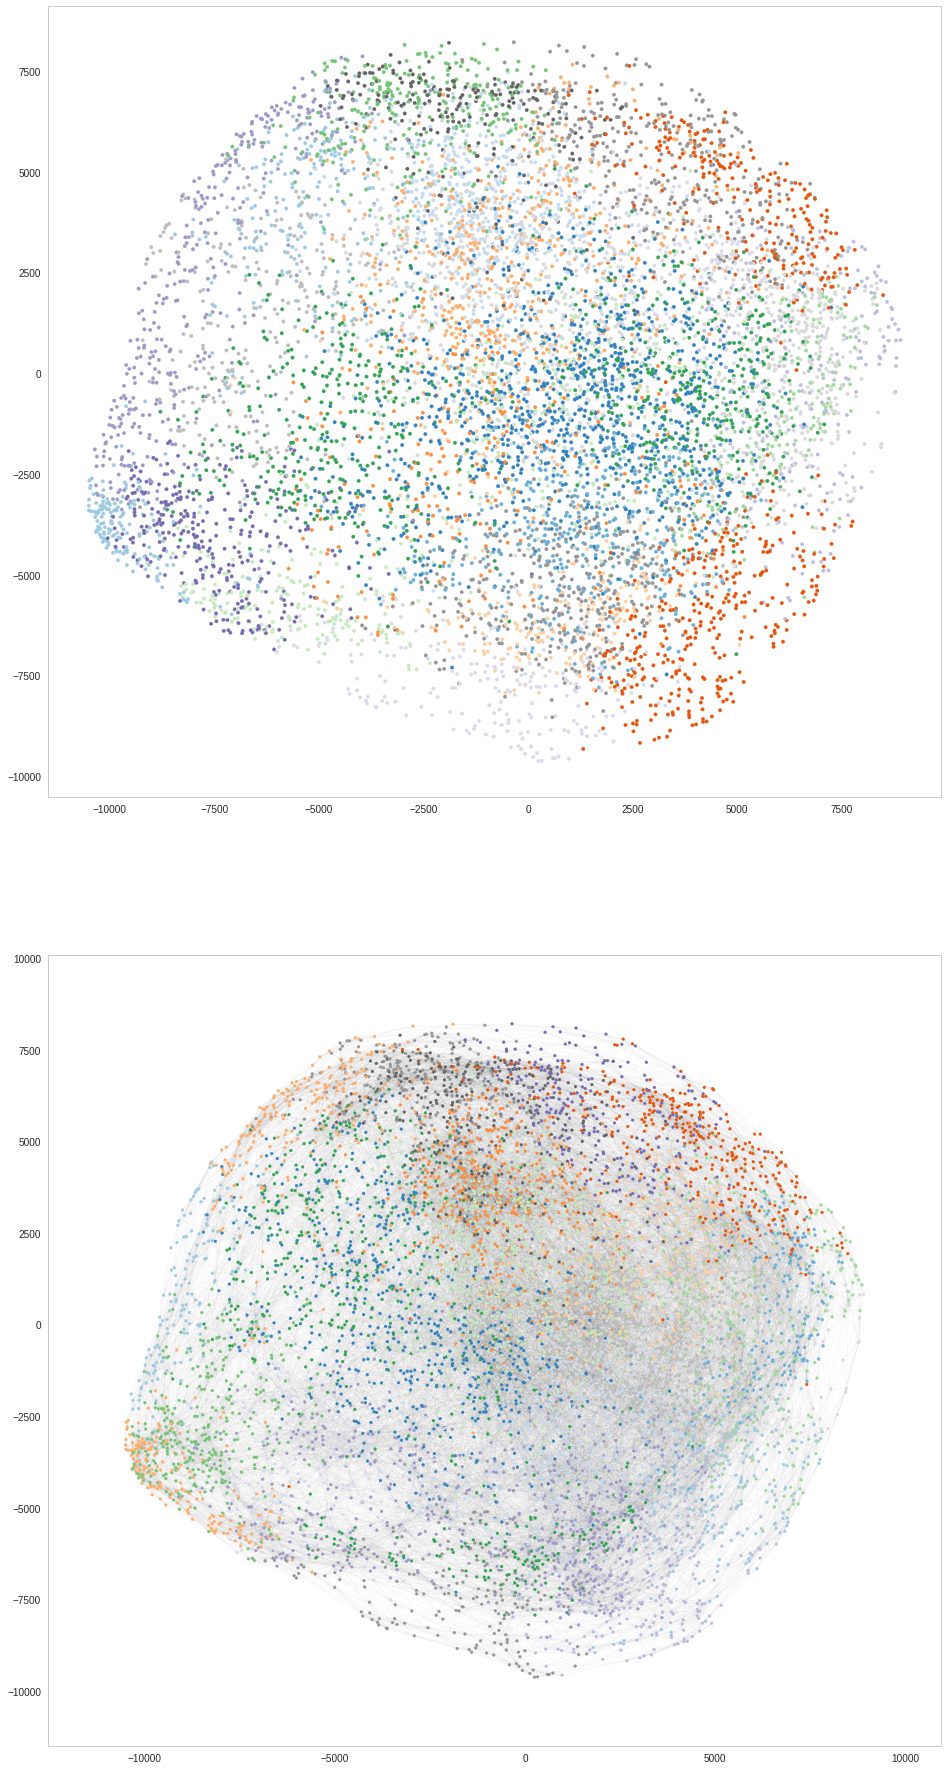

In [256]:
plt.figure(figsize=(16,32))
plt.subplot(2, 1, 1)
nx.draw_networkx_nodes(gx, p, node_size=12, with_labels=False, width=.004, node_color=gm, cmap='tab20c')
plt.subplot(2,1,2)
nx.draw_networkx(gx, p, node_size=8, with_labels=False, width=.01, node_color=gm1, cmap='tab20c')
# plt.savefig("fd.pdf")

In [280]:
from sklearn.metrics import silhouette_score, calinski_harabaz_score

sc = silhouette_score(dm, labels=gm1, metric='precomputed', sample_size=None)

ch = calinski_harabaz_score(g_all[:,0:64], agc)
sc, ch

(-0.13282881606763672, 90.18709990929212)